# TensorFlow Datasets
In this assignment you will create a data pipeline with for a cool Rock Paper Scissors model

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

## 1. Loading Dataset
load the Rock Paper Scissors Dataset from TFDS:
https://www.tensorflow.org/datasets/catalog/rock_paper_scissors \
This Dataset have two splits: Train, Test\
In here we want three splits: Train, Validation and Test. So we should use TFDS split method to keep 80% of original Train split for training set, remaining 20% for validation set and all of the original Test split for test set:

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'rock_paper_scissors',
    split=['train[:80%]', 'train[80%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [3]:
train_ds.element_spec

(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## 2. Inspecting Dataset

In [4]:
num_classes = metadata.features['label'].num_classes
get_label_name = metadata.features['label'].int2str
print(f"Number of classes in the dataset: {num_classes}")
for i in range(num_classes):
    print(f"class id {i} is {get_label_name(i)}")

Number of classes in the dataset: 3
class id 0 is rock
class id 1 is paper
class id 2 is scissors


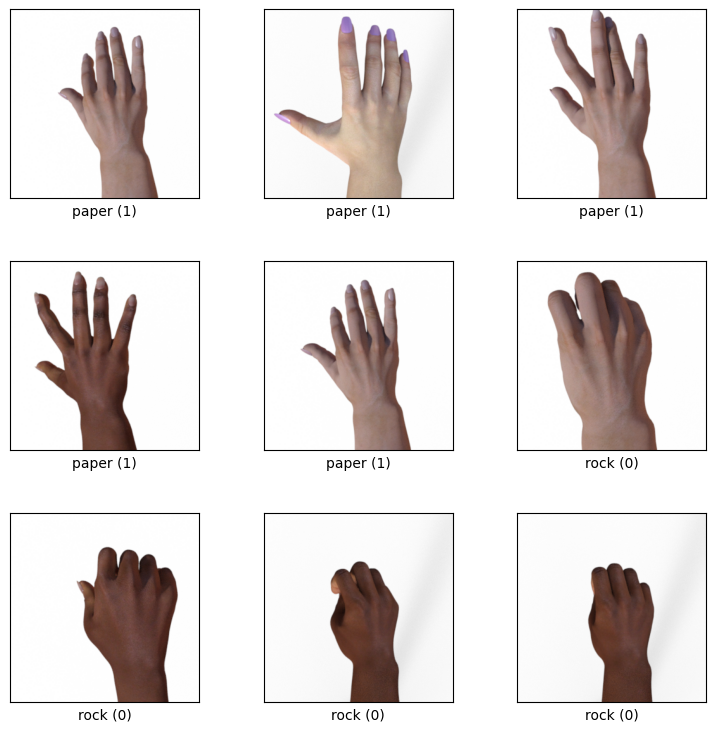

In [5]:

fig = tfds.show_examples(train_ds, metadata)

## 3. Preprocessing


In [6]:
NUM_CLASSES = metadata.features['label'].num_classes

def preprocess(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0


    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label


## 4. Data Augmentation
Create a sequential model with three augmentation layer:
1. [Random Flip](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/)
2. [Random Rotation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/)


In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

###5. shuffle for training -> preprocess for all -> Aug for training -> cache

Shuffle training data and batch all splits

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
buffer_size = 1000

# Training set: shuffle → preprocess → augment → batch → prefetch
train_ds = (train_ds
            .shuffle(buffer_size)
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .map(lambda x, y: (data_augmentation(x, training=True), y),
                 num_parallel_calls=AUTOTUNE)
            .batch(batch_size)
            .prefetch(AUTOTUNE))

# Validation set: preprocess → batch → prefetch
val_ds = (val_ds
          .map(preprocess, num_parallel_calls=AUTOTUNE)
          .batch(batch_size)
          .prefetch(AUTOTUNE))

# Test set: preprocess → batch → prefetch
test_ds = (test_ds
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(batch_size)
           .prefetch(AUTOTUNE))


In [12]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

Add cache and prefetch for optimizing the pipeline:

In [13]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

In [14]:
train_ds.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))

## 6. Model Creation and Training

In [15]:
input_shape = (224, 224, 3)
num_classes = 3

input = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", name="first_conv")(input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
pred = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=input, outputs=pred)

In [16]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=["accuracy"],
)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

test_scores = model.evaluate(test_ds, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step - accuracy: 0.4324 - loss: 1.2291 - val_accuracy: 0.6587 - val_loss: 0.7709
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7662 - loss: 0.5536 - val_accuracy: 0.7857 - val_loss: 0.4775
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9031 - loss: 0.2561 - val_accuracy: 0.8056 - val_loss: 0.4341
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9646 - loss: 0.1217 - val_accuracy: 0.8095 - val_loss: 0.4181
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9822 - loss: 0.0677 - val_accuracy: 0.7679 - val_loss: 0.7257
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9806 - loss: 0.0619 - val_accuracy: 0.8016 - val_loss: 0.5151
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9779 - loss: 0.0720 - val_accuracy: 0.8790 - val_loss: 0.3974
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9918 - loss: 0.0364 - val_ac